In [41]:
!pip uninstall qiskit_nature --yes
!pip uninstall pyscf --yes

In [1]:
!pip install qiskit
!pip install qiskit_algorithms
!pip install qiskit-nature[pyscf]

In [2]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.drivers import PySCFDriver
from numpy import sin
from numpy import cos
from numpy import pi
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
import pyscf



def get_groundstate_energy(distance):
    driver = PySCFDriver(
        atom="O 0 0 0; H 0 "+str(distance*sin(52/180*pi))+" "+str(distance*cos(52/180*pi))+"; H 0 "+str(-distance*sin(52/180*pi))+" "+str(distance*cos(52/180*pi)),
        #atom = "H 0 0 0; H 0 0 "+str(distance),
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
        max_cycle = 1,
    )

    es_problem = driver.run()

    es_problem = FreezeCoreTransformer().transform(es_problem)

    mapper = JordanWignerMapper()
    tapered_mapper = es_problem.get_tapered_mapper(mapper)

    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state= HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

    ansatz2 = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        tapered_mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            tapered_mapper,
        ),
    )

    numpy_solver = NumPyMinimumEigensolver()
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    vqe_solver2 = VQE(Estimator(), ansatz2, SLSQP())
    vqe_solver2.initial_point = [0.0] * ansatz2.num_parameters

    #calc1 = GroundStateEigensolver(mapper, numpy_solver)
    #calc2 = GroundStateEigensolver(mapper, vqe_solver)
    calc3 = GroundStateEigensolver(tapered_mapper, numpy_solver)
    calc4 = GroundStateEigensolver(tapered_mapper, vqe_solver2)
    #res1 = calc1.solve(es_problem)
    #res2 = calc2.solve(es_problem)
    res3 = calc3.solve(es_problem)
    res4 = calc4.solve(es_problem)
    return res3.total_energies, res4.total_energies




In [7]:
g1 = []
g2 = []
g3 = []
g4 = []
for i in range(3, 35):
    print(".", end = "")
    g03, g04= get_groundstate_energy(i/10)
    # g1.append(g01[0])
    # g2.append(g02[0])
    g3.append(g03[0])
    g4.append(g04[0])
print("done")

.

<ipython-input-2-491671c354b2>:59: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz, SLSQP())
<ipython-input-2-491671c354b2>:61: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver2 = VQE(Estimator(), ansatz2, SLSQP())


...............................done


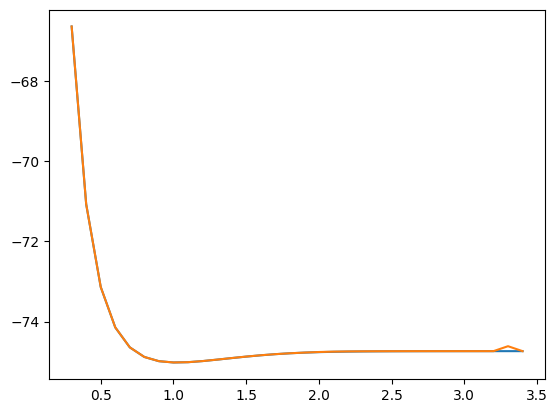

In [9]:
import matplotlib.pyplot as plt
axis = [i/10 for i in range(3, 35)]


# plt.plot(axis, g1)
# plt.plot(axis, g2)
plt.plot(axis, g3)
plt.plot(axis, g4)